In [31]:
import pandas as pd 
import numpy as np
import ast
import shap
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, classification_report, r2_score, mean_absolute_error, mean_squared_error, confusion_matrix

## Data Collection & Merging

In [5]:
df = pd.read_csv('./data/uncleaned_data.csv')
df.head()

,Unnamed: 0.1,name,club_x,injuries,Unnamed: 0,nationality,position,club_y,age,birth_year,...,touches_live_ball,dribbles,miscontrols,dispossessed,passes_received,fouls,fouled,ball_recoveries,aerials_won,"aerials_lost,"
0,0,Ederson,Manchester City,"[('20/21', 'Virus Infection', 'Dec 27, 2020', ...",689,br BRA,GK,Manchester City,29-100,1993,...,547.0,0.0,0.0,0.0,345.0,0.0,2.0,19.0,3.0,"0.0,"
1,1,Rúben Dias,Manchester City,"[('21/22', 'Knock', 'Mar 3, 2022', 'Apr 11, 20...",615,pt POR,DF,Manchester City,25-195,1997,...,972.0,3.0,0.0,0.0,762.0,10.0,3.0,41.0,26.0,"13.0,"
2,2,Aymeric Laporte,Manchester City,"[('22/23', 'Knee Surgery', 'Jun 30, 2022', 'Oc...",1232,es ESP,DF,Manchester City,28-182,1994,...,279.0,2.0,1.0,0.0,216.0,0.0,2.0,11.0,11.0,"4.0,"
3,3,John Stones,Manchester City,"[('22/23', 'Hamstring Injury', 'Sep 26, 2022',...",2101,eng ENG,DF,Manchester City,28-181,1994,...,686.0,5.0,3.0,1.0,541.0,3.0,3.0,37.0,10.0,"6.0,"
4,4,Nathan Aké,Manchester City,"[('20/21', 'Hamstring Injury', 'Dec 27, 2020',...",37,nl NED,DF,Manchester City,27-280,1995,...,648.0,0.0,3.0,0.0,538.0,2.0,4.0,24.0,13.0,"10.0,"


In [3]:
ratings_data = pd.read_csv('./data/final_ratings.csv')
ratings_data.head()

,FC 25,FC 24,Name,FIFA 23,FIFA 22,FIFA 21,FIFA 20,FIFA 19,FIFA 18,FIFA 17,FIFA 16,FIFA 15,FIFA 14/25,FIFA 13,FIFA 12,FIFA 11,FIFA 10,FIFA 09,FIFA 08,FIFA 07
0,80.0,77.0,ederson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,88.0,89.0,rúben-dias,88.0,87.0,81.0,80.0,78.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,83.0,85.0,aymeric-laporte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,85.0,85.0,john-stones,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84.0,81.0,nathan-aké,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# 3. Define working copy
injury_flat = df.copy()

In [7]:
injury_flat = []

for i, row in df.iterrows():
    name = row['name']
    age = row['age']
    dribbles = row['dribbles']
    fouls = row['fouls']
    fouled = row['fouled']
    passes_received = row['passes_received']

    try:
        injuries = ast.literal_eval(row['injuries'])
    except:
        continue  # skip if format is invalid

    for injury in injuries:
        try:
            season, injury_type, start, end, days, matches = injury
            days = int(days)  # convert to integer
            injury_flat.append({
                'name': name,
                'age': age,
                'dribbles': dribbles,
                'fouls': fouls,
                'fouled': fouled,
                'passes_received': passes_received,
                'injury_type': injury_type,
                'days_injured': days
            })
        except:
            continue

injury_flat = pd.DataFrame(injury_flat)

In [8]:
def extract_region_fixed(injury):
    if pd.isna(injury): return 'other'
    injury = str(injury).lower()

    # Specific reclassifications
    if 'toe' in injury: return 'foot'
    if 'biceps femoris' in injury: return 'hamstring'
    if 'adductor' in injury or 'abductor' in injury: return 'groin'
    if 'quadriceps' in injury: return 'thigh'
    if 'tendon' in injury: return 'knee'
    if 'fibre' in injury or 'muscle' in injury or 'strain' in injury or 'tear' in injury:
        if 'hamstring' in injury: return 'hamstring'
        if 'thigh' in injury: return 'thigh'
        if 'calf' in injury: return 'calf'
        if 'groin' in injury: return 'groin'
        return 'hamstring'
    if 'bruise' in injury:
        for part in ['knee', 'ankle', 'foot', 'head', 'rib', 'hip', 'thigh']:
            if part in injury:
                return part
        return 'thigh'

    # General part match
    parts = [
        'knee', 'ankle', 'hamstring', 'groin', 'hip', 'foot', 'back',
        'shoulder', 'rib', 'arm', 'hand', 'thigh', 'calf', 'pelvis',
        'neck', 'head', 'chest', 'lung'
    ]
    for part in parts:
        if part in injury:
            return part
    return 'other'

In [9]:
def categorize_severity(days):
    if pd.isna(days): return 'unknown'
    days = int(days)
    if days < 4: return 'mild'
    elif days < 10: return 'moderate'
    else: return 'severe'

In [10]:
# Normalize names for merging
injury_flat['name'] = injury_flat['name'].str.lower().str.replace('-', ' ').str.strip().apply(unidecode)
ratings_data['Name'] = ratings_data['Name'].str.lower().str.replace('-', ' ').str.strip().apply(unidecode)

# Region mapping
injury_flat['region'] = injury_flat['injury_type'].apply(extract_region_fixed)

# Filter irrelevant
drop_keywords = ['cold', 'fever', 'quarantine', 'fitness', 'rest', 'appendectomy', 'abdominal', 'abdomen', 'surgery']
injury_flat = injury_flat[~injury_flat['injury_type'].str.lower().str.contains('|'.join(drop_keywords), na=False)]
injury_flat = injury_flat[injury_flat['region'] != 'other']

# Categorize severity
injury_flat['severity_level'] = injury_flat['days_injured'].apply(categorize_severity)
injury_flat['injury_group'] = injury_flat['region'] + '_' + injury_flat['severity_level']

# Pivot to wide format
injury_matrix = injury_flat.pivot_table(
    index=['name', 'age', 'dribbles', 'fouls', 'fouled', 'passes_received'],
    columns='injury_group',
    values='days_injured',
    aggfunc='sum',
    fill_value=0
).reset_index()

# Merge with FIFA ratings
injury_matrix['name_clean'] = injury_matrix['name'].str.lower().str.replace('-', ' ').str.strip().apply(unidecode)
ratings_data['Name_clean'] = ratings_data['Name'].str.lower().str.replace('-', ' ').str.strip().apply(unidecode)

injury_matrix = injury_matrix.merge(
    ratings_data[['Name_clean', 'FC 24', 'FC 25']].drop_duplicates(),
    left_on='name_clean',
    right_on='Name_clean',
    how='left'
)

injury_matrix.drop(columns=['name_clean', 'Name_clean'], inplace=True)

# Final checks
print("Final DataFrame Shape:", injury_matrix.shape)
print(" Non-null FIFA 24 ratings:", injury_matrix['FC 24'].notna().sum())
print(" Non-null FIFA 25 ratings:", injury_matrix['FC 25'].notna().sum())
print(" 'other_*' columns present:", injury_matrix.columns[injury_matrix.columns.str.startswith('other')].tolist())
print(" Total days injured:",
      int(injury_matrix.drop(columns=['name', 'age', 'dribbles', 'fouls', 'fouled', 'passes_received', 'FC 24', 'FC 25']).sum().sum()))
print("Example injury columns:",
      [col for col in injury_matrix.columns if '_' in col][:5])

Final DataFrame Shape: (1489, 57)
 Non-null FIFA 24 ratings: 1438
 Non-null FIFA 25 ratings: 1440
 'other_*' columns present: []
 Total days injured: 204326
Example injury columns: ['passes_received', 'ankle_mild', 'ankle_moderate', 'ankle_severe', 'arm_mild']


In [11]:
print("injury_matrix shape:", injury_matrix.shape)
print("Does injury_matrix have FIFA 24?", 'FC 24' in injury_matrix.columns)
print("injury_matrix non-null FIFA 24:", injury_matrix['FC 24'].notna().sum())
print("Does injury_summary have FIFA 25?", 'FC 25' in injury_matrix.columns)
print("injury_summary non-null FIFA 25:", injury_matrix['FC 25'].notna().sum())

# Just in case you're actually looking at another DataFrame
try:
    print("injury_summary shape:", injury_summary.shape)
    print("Does injury_summary have FIFA 24?", 'FC 24' in injury_summary.columns)
    print("Does injury_summary have FIFA 25?", 'FC 25' in injury_summary.columns)
    print("injury_summary non-null FIFA 24:", injury_summary['FC 24'].notna().sum())
    print("injury_summary non-null FIFA 25:", injury_summary['FC 25'].notna().sum())
except:
    print("injury_summary not defined.")

injury_matrix shape: (1489, 57)
Does injury_matrix have FIFA 24? True
injury_matrix non-null FIFA 24: 1438
Does injury_summary have FIFA 25? True
injury_summary non-null FIFA 25: 1440
injury_summary not defined.


In [12]:
ratings_data[['Name_clean', 'FC 24', 'FC 25']].drop_duplicates()

,Name_clean,FC 24,FC 25
0,ederson,77.0,80.0
1,ruben dias,89.0,88.0
2,aymeric laporte,85.0,83.0
3,john stones,85.0,85.0
4,nathan ake,81.0,84.0
...,...,...,...
1919,alex collado,70.0,70.0
1920,josan,72.0,72.0
1921,lucas boye,77.0,76.0
1922,ezequiel ponce,73.0,75.0


In [13]:
# Clean names again
injury_matrix['name_clean'] = injury_matrix['name'].str.lower().str.replace('-', ' ').str.strip().apply(unidecode)
ratings_data['Name_clean'] = ratings_data['Name'].str.lower().str.replace('-', ' ').str.strip().apply(unidecode)

# Drop if 'FC 24' already exists from bad merge
if 'FC 24' in injury_matrix.columns:
    injury_matrix = injury_matrix.drop(columns=['FC 24'])

# Merge FIFA 24 scores
injury_matrix = injury_matrix.merge(
    ratings_data[['Name_clean', 'FC 24', 'FC 25']].drop_duplicates(),
    left_on='name_clean',
    right_on='Name_clean',
    how='left'
)

# Drop temp columns
injury_matrix.drop(columns=['name_clean', 'Name_clean'], inplace=True)

# Show results
print("✅ Final FIFA 24 matches:", injury_matrix['FC 24'].notna().sum())
print("❌ Still unmatched:", injury_matrix['FC 24'].isna().sum())

✅ Final FIFA 24 matches: 1438
❌ Still unmatched: 51


In [14]:
# Keep FC 25_x and rename it to FC25
injury_matrix['FC25'] = injury_matrix['FC 25_x']

# Drop the old FC 25 columns
injury_matrix = injury_matrix.drop(columns=['FC 25_x', 'FC 25_y'])

# Now drop rows missing FIFA ratings
injury_matrix = injury_matrix.dropna(subset=['FC 24', 'FC25']).reset_index(drop=True)

print("✅ After cleaning and dropping NaNs, shape:", injury_matrix.shape)

✅ After cleaning and dropping NaNs, shape: (1437, 57)


In [15]:
# Select only the injury columns (excluding metadata and FC 24 score)
injury_cols = [col for col in df.columns if col not in ['name', 'age', 'dribbles', 'fouls', 'fouled', 'passes_received', 'FC 24']]

# Find columns where the sum of all values is 0 (i.e., no injuries recorded)
no_injury_cols = [col for col in injury_cols if df[col].sum() == 0]

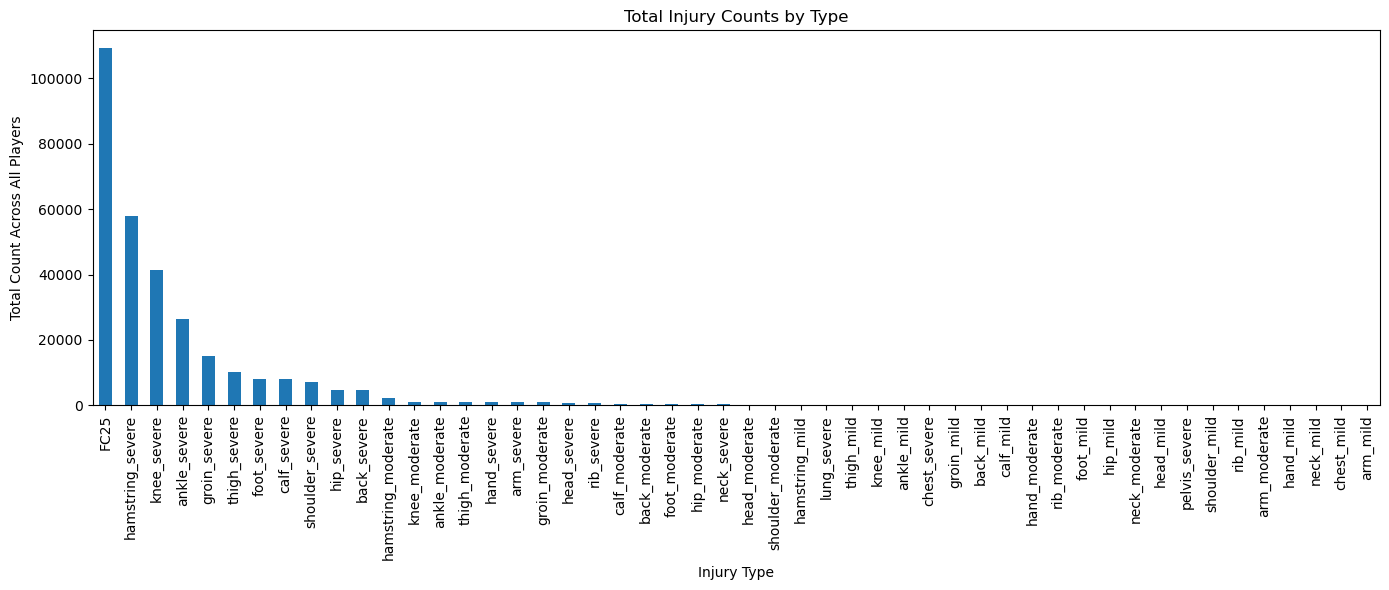

In [16]:
# Select only the injury columns (excluding metadata like name, age, FIFA score, etc.)
injury_columns = injury_matrix.columns.difference(['name', 'age', 'dribbles', 'fouls', 'fouled', 'passes_received', 'FC 24'])

# Sum the injury counts for each column
injury_totals = injury_matrix[injury_columns].sum().sort_values(ascending=False)

# Plot the totals
plt.figure(figsize=(14, 6))
injury_totals.plot(kind='bar')
plt.title('Total Injury Counts by Type')
plt.xlabel('Injury Type')
plt.ylabel('Total Count Across All Players')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [17]:
# Identify injury columns again (excluding metadata columns)
injury_columns = injury_matrix.columns.difference(['name', 'age', 'dribbles', 'fouls', 'fouled', 'passes_received', 'FC 24'])

# Sum total injury days for each column
injury_totals = injury_matrix[injury_columns].sum().sort_values()

# Show the bottom 10 injury types
print("🔻 Bottom 10 injury types by total days:")
print(injury_totals.head(10))

🔻 Bottom 10 injury types by total days:
arm_mild          1.0
neck_mild         3.0
chest_mild        3.0
hand_mild        10.0
rib_mild         12.0
arm_moderate     12.0
shoulder_mild    13.0
pelvis_severe    14.0
head_mild        23.0
neck_moderate    25.0
dtype: float64


In [18]:
# List columns that are actual injury durations (not metadata or ratings)
exclude = ['name', 'age', 'dribbles', 'fouls', 'fouled', 'passes_received', 'FC 24']
injury_cols = [col for col in injury_matrix.columns if col not in exclude]

# Sum total days injured
total_days_now = injury_matrix[injury_cols].sum().sum()
print("✅ Total days injured (cleaned dataset):", int(total_days_now))

✅ Total days injured (cleaned dataset): 305745


In [19]:
# List injury columns (exclude metadata + FIFA)
exclude = ['name', 'age', 'dribbles', 'fouls', 'fouled', 'passes_received', 'FC 24']
injury_cols = [col for col in injury_matrix.columns if col not in exclude]

# Count players with all-zero injuries
players_with_no_injuries = (injury_matrix[injury_cols].sum(axis=1) == 0).sum()
players_with_injuries = len(injury_matrix) - players_with_no_injuries

print(f"🟢 Players WITH at least one injury: {players_with_injuries}")
print(f"🔘 Players with NO injuries at all: {players_with_no_injuries}")

🟢 Players WITH at least one injury: 1437
🔘 Players with NO injuries at all: 0


In [20]:
injury_matrix["rating_change"] = injury_matrix["FC25"] - injury_matrix["FC 24"]

## Modeling & Evaluation

In [21]:
# Drop only existing columns
X = injury_matrix.drop(columns=['name', 'age', 'dribbles', 'fouls', 'fouled', 'passes_received', 'rating_change', 'FC24', 'FC25'], errors='ignore')
y = injury_matrix['rating_change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Random Forest Results:
R²: -0.1998
MAE: 1.3596
RMSE: 1.7651

Gradient Boosting Results:
R²: -0.2504
MAE: 1.3789
RMSE: 1.8020

Decision Tree Results:
R²: -1.0003
MAE: 1.7500
RMSE: 2.2791

Linear Regression Results:
R²: -0.1176
MAE: 1.2915
RMSE: 1.7035

Baseline Model (predicting mean):
MAE: 1.1801
RMSE: 1.6115


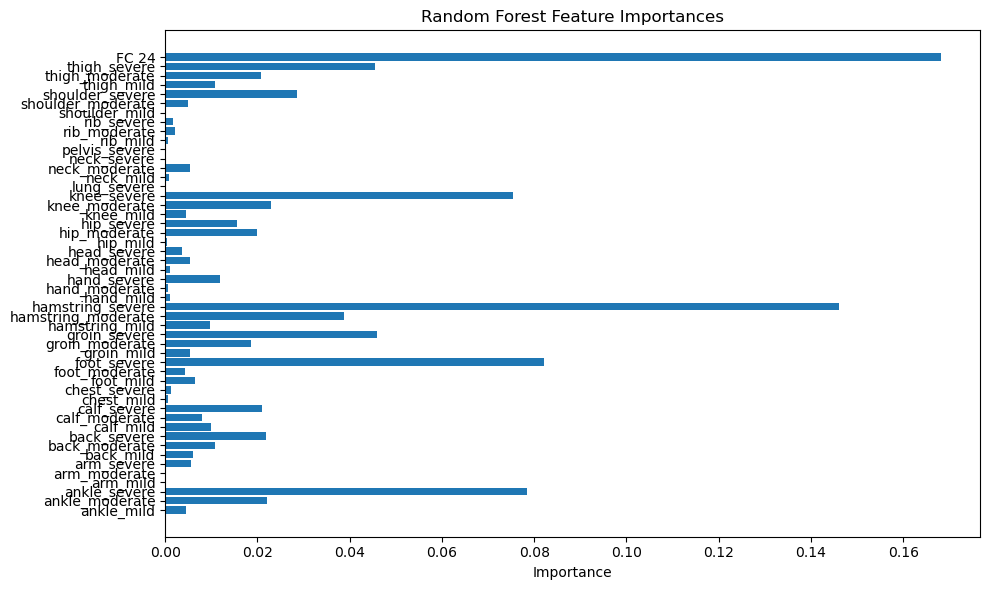

In [24]:
# Split features and target
X = injury_matrix.drop(columns=['name', 'age', 'dribbles', 'fouls', 'fouled', 'passes_received', 'rating_change', 'FC24', 'FC25'], errors='ignore')
y = injury_matrix['rating_change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Helper function for evaluating models
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n{name} Results:")
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    return {"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse}

# Store results
results = []

# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
results.append(evaluate_model("Random Forest", y_test, rf_pred))

# Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42, max_depth=6)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
results.append(evaluate_model("Gradient Boosting", y_test, gb_pred))

# Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
results.append(evaluate_model("Decision Tree", y_test, dt_pred))

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
results.append(evaluate_model("Linear Regression", y_test, lr_pred))

# Baseline (predict mean)
baseline = y_test.mean()
baseline_mae = mean_absolute_error(y_test, [baseline] * len(y_test))
baseline_rmse = np.sqrt(mean_squared_error(y_test, [baseline] * len(y_test)))
print(f"\nBaseline Model (predicting mean):")
print(f"MAE: {baseline_mae:.4f}")
print(f"RMSE: {baseline_rmse:.4f}")

# Convert results to DataFrame
import pandas as pd
results_df = pd.DataFrame(results)
#from ace_tools import display_dataframe_to_user
#display_dataframe_to_user(name="Model Evaluation Summary", dataframe=results_df)

# Feature Importance Plot
importances = rf_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

    decrease       0.37      0.40      0.38       115
    increase       0.46      0.39      0.42        74
   no_change       0.36      0.36      0.36        99

    accuracy                           0.39       288
   macro avg       0.40      0.39      0.39       288
weighted avg       0.39      0.39      0.39       288

Confusion Matrix:
[[46 18 51]
 [31 29 14]
 [47 16 36]]


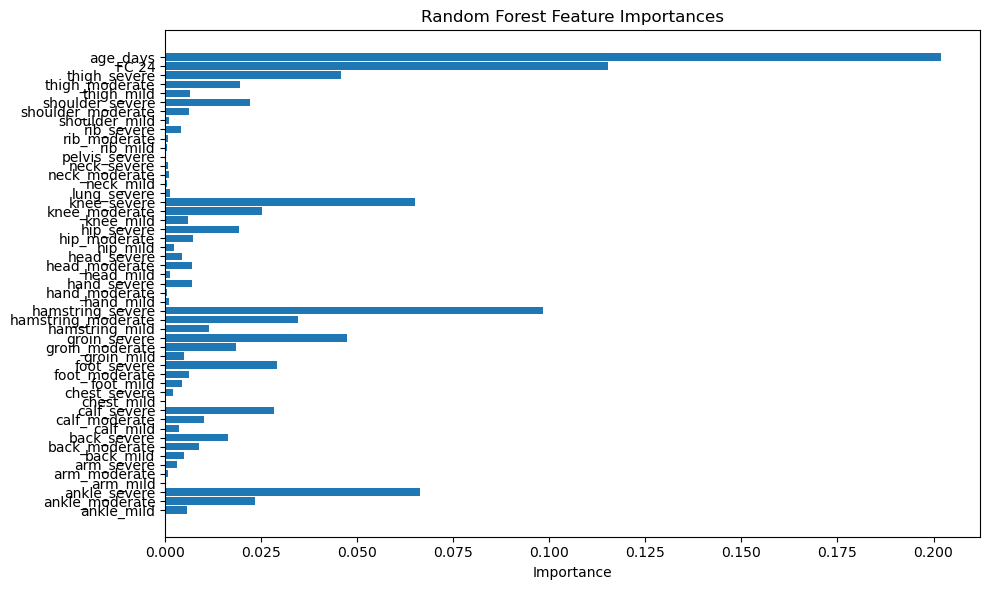

In [28]:
# 2. Create target label: increase, decrease, no_change
injury_matrix['rating_trend'] = injury_matrix['rating_change'].apply(
    lambda x: 'increase' if x > 0 else ('decrease' if x < 0 else 'no_change')
)

# 3. Convert age from "years-days" to total days
injury_matrix['age_days'] = injury_matrix['age'].str.split('-').apply(
    lambda x: int(x[0]) * 365 + int(x[1]) if isinstance(x, list) and len(x) == 2 else np.nan
)

# 4. Select features and target
X = injury_matrix.drop(columns=[
    'name', 'age', 'dribbles', 'fouls', 'fouled', 'passes_received',
    'rating_change', 'rating_trend', 'FC24', 'FC25', 'FC 25_x', 'FC 25_y'
], errors='ignore')

# Add age_days to features
X['age_days'] = injury_matrix['age_days']

# Fill missing values
X = X.fillna(0)

# Target
y = injury_matrix['rating_trend']

# 5. Train/test split (stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 6. Train classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# 7. Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 8. Feature Importance
importances = clf.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [32]:
shap.initjs()

In [33]:
# Find a test case matching the pattern
condition = (X_test['knee_severe'] == 1) & (X_test['age_days'] > 12000)
matching_indices = X_test[condition].index

# Pick the first one to explain
if len(matching_indices) > 0:
    sample_idx = matching_indices[0]
    sample = X_test.loc[[sample_idx]]
    print("Sample index found:", sample_idx)
else:
    print("No matching sample found.")

No matching sample found.


In [34]:
# Step 1: Create synthetic player
fake_player = X_test.mean().copy()
fake_player['knee_severe'] = 1
fake_player['age_days'] = 13500
fake_player_df = pd.DataFrame([fake_player])

# Step 2: Predict class
predicted_class = clf.predict(fake_player_df)[0]
print("🔮 Predicted rating trend:", predicted_class)

# Step 3: SHAP explainer
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(fake_player_df)

# Step 4: Get class index
class_idx = list(clf.classes_).index(predicted_class)

# Step 5: Print lengths to debug
print("Number of features:", len(fake_player_df.columns))
print("Number of SHAP values:", len(shap_values[class_idx][0]))
print("Shape of SHAP values:", shap_values.shape)

# Step 6: Ensure lengths match before plotting
if len(fake_player_df.columns) == len(shap_values[class_idx][0]):
    shap.initjs()
    shap.force_plot(
        base_value=explainer.expected_value[class_idx],
        shap_values=shap_values[class_idx][0],
        features=fake_player_df.iloc[0].values,
        feature_names=fake_player_df.columns.tolist()
    )
else:
    print("Mismatch in lengths of features and SHAP values.")

🔮 Predicted rating trend: decrease
Number of features: 51
Number of SHAP values: 3
Shape of SHAP values: (1, 51, 3)
Mismatch in lengths of features and SHAP values.


In [35]:
# Step 1: Create synthetic player
fake_player = X_test.mean().copy()
fake_player['knee_severe'] = 1
fake_player['age_days'] = 13500
fake_player_df = pd.DataFrame([fake_player])

# Step 2: Predict class
predicted_class = clf.predict(fake_player_df)[0]
print("🔮 Predicted rating trend:", predicted_class)

# Step 3: SHAP explainer
explainer = shap.TreeExplainer(clf)
shap_values = explainer(fake_player_df)

# Step 4: Get SHAP values for the predicted class
shap_values_for_class = shap_values.values[:, :, class_idx]

# Step 5: Ensure lengths match before plotting
if len(fake_player_df.columns) == shap_values_for_class.shape[1]:
    shap.initjs()
    shap.force_plot(
        base_value=explainer.expected_value[class_idx],
        shap_values=shap_values_for_class[0],
        features=fake_player_df.iloc[0].values,
        feature_names=fake_player_df.columns.tolist()
    )
else:
    print("Mismatch in lengths of features and SHAP values.")

🔮 Predicted rating trend: decrease


In [36]:
# Split features and target
X = injury_matrix.drop(columns=['name', 'age' , 'rating_change', 'FC25', 'rating_trend'], errors='ignore')
y = injury_matrix['rating_change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Helper function for evaluating models
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n{name} Results:")
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    return {"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse}

# Store results
results = []

# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
results.append(evaluate_model("Random Forest", y_test, rf_pred))

# Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42, max_depth=6)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
results.append(evaluate_model("Gradient Boosting", y_test, gb_pred))

# Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
results.append(evaluate_model("Decision Tree", y_test, dt_pred))

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
results.append(evaluate_model("Linear Regression", y_test, lr_pred))


Random Forest Results:
R²: -0.1290
MAE: 1.2933
RMSE: 1.7122

Gradient Boosting Results:
R²: -0.2978
MAE: 1.3049
RMSE: 1.8358

Decision Tree Results:
R²: -2.1757
MAE: 1.9965
RMSE: 2.8717

Linear Regression Results:
R²: 0.0198
MAE: 1.2288
RMSE: 1.5954


In [37]:
# Decision Tree Classifier
dtc_model = DecisionTreeClassifier(random_state=42)
dtc_model.fit(X_train, y_train)

print("Decision Tree R^2 score:", dtc_model.score(X_test, y_test))

y_pred_dtc = dtc_model.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_dtc)
print(f"Decision Tree Accuracy: {accuracy}")

# Classification Report
print(f"Classification Report:\n{classification_report(y_test, y_pred_dtc)}")

Decision Tree R^2 score: 0.21875
Decision Tree Accuracy: 0.21875
Classification Report:
              precision    recall  f1-score   support

        -5.0       0.00      0.00      0.00         0
        -4.0       0.00      0.00      0.00         4
        -3.0       0.00      0.00      0.00         9
        -2.0       0.13      0.12      0.13        40
        -1.0       0.20      0.23      0.21        64
         0.0       0.38      0.38      0.38        97
         1.0       0.11      0.08      0.09        36
         2.0       0.17      0.12      0.14        17
         3.0       0.00      0.00      0.00        12
         4.0       0.25      0.14      0.18         7
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         1
         8.0       0.00      0.00      0.00         0
         9.0       0.00      0.00      0.00         0

    accuracy                           0.22       288
   macro avg       0.09      0.08      0.08   

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
# Gradient Boosting Tree Classifier
gbc_model = GradientBoostingClassifier(max_depth=6, random_state=42)
gbc_model.fit(X_train, y_train)

# Evaluate
print("Gradient Boosting R^2 score:", gbc_model.score(X_test, y_test))

y_pred_gbc = gbc_model.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_gbc)
print(f"Decision Tree Accuracy: {accuracy}")

# Classification Report
print(f"Classification Report:\n{classification_report(y_test, y_pred_gbc)}")

Gradient Boosting R^2 score: 0.2673611111111111
Decision Tree Accuracy: 0.2673611111111111
Classification Report:
              precision    recall  f1-score   support

        -8.0       0.00      0.00      0.00         0
        -5.0       0.00      0.00      0.00         0
        -4.0       0.00      0.00      0.00         4
        -3.0       0.00      0.00      0.00         9
        -2.0       0.13      0.05      0.07        40
        -1.0       0.20      0.16      0.18        64
         0.0       0.36      0.62      0.45        97
         1.0       0.17      0.11      0.14        36
         2.0       0.12      0.06      0.08        17
         3.0       0.00      0.00      0.00        12
         4.0       0.00      0.00      0.00         7
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         1

    accuracy                           0.27       288
   macro avg       0.08      0.08      0.07       288
weighted avg       0

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
